## Problem Statement: Predict Potential Talents.

### Data Description:

The data comes from our sourcing efforts. We removed any field that could directly reveal personal details and gave a unique identifier for each candidate.

`Attributes`:
* id : unique identifier for candidate (numeric)

* job_title : job title for candidate (text)

* location : geographical location for candidate (text)

* connections: number of connections candidate has, 500+ means over 500 (text)

`Output (desired target)`:
* fit - how fit the candidate is for the role? (numeric, probability between 0-1)

`Keywords`: “Aspiring human resources” or “seeking human resources”


### Summary of this notebook:

We want to predict how fit the candidate is based on their unique identifiers, their job titles, geographical location and number of connections each candidate has. 

Given the above keywords, we can first find the similarities between them and the job titles. After finding these similarities, we will then rank candidates based on them. 

We will use methods like jaccard and cosine similarities to find the similarity scores we'll use as the fitness score. 
`Jaccard Similarity` takes in the text data as inputs but `Cosine Similarity` takes in numbers as input. This means that we'll have to represent our data as numerical vectors using methods like word embeddings (word2vec and glove) that are context independent and BERT embeddings which learns contextual representations on unlabeled data.


### Starting with the Dev Work...

In [1]:
#Download missing packages
!pip install wget
!pip install sentence_transformers

  Preparing metadata (setup.py) ... -

 done


 \

 done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=48063b28edcd49f67a175272c02ca64df4304bb8229133a05f50ee86e3471388
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02


Successfully built wget


     ━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/86.0 kB 1.1 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/86.0 kB 1.1 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 656.0 kB/s eta 0:00:00


  Preparing metadata (setup.py) ... -

 done


 \

 |

 done
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=dd014833bf86aeb81fb4f08013ce2909ad6911afbaeb55edbf17a02adf01aa7c
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence_transformers


In [2]:
# imports
import numpy as np
import pandas as pd

pd.options.mode.chained_assignment = None # 

import warnings

from wordcloud import WordCloud # visualize text data where size of each word indicates its frequency or importance
import matplotlib.pyplot as plt 
import scipy.stats as stats # statistics, probability distributions functions

import sklearn
from sklearn.metrics.pairwise import cosine_similarity # measure how similar the documents are irrespective of their size
from scipy.spatial.distance import cosine # returns the angle between the two given point A and B


import shutil # helps in automating the process of copying and removal of files and directorie
import re
import string
import spacy 
import os
import wget 

import nltk
nltk.download('stopwords') # the most common words in any language (like articles, prepositions, pronouns, conjunctions, etc) and does not add much info to the text
nltk.download('wordnet') # used to look for word definitions, synonyms, and antonyms
nltk.download('punkt') # PunktSentenceTokenizer: divides a text into a list of sentences by using an unsupervised algorithm to build a model for abbreviation words, collocations, and words that start sentences

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize #  divides a body of text into words or sentences

import gensim 
import gensim.downloader as api # 
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
from gensim.models.doc2vec import Doc2Vec

from sentence_transformers import SentenceTransformer

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# import data
data = pd.read_csv('../input/seeking-human-resources/potential-talents - Aspiring human resources - seeking human resources.csv')

In [4]:
# View the first 5 rows of our data
data.head()

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB


Our dataset contains 5 columns, 3 contain categorical data types,no missing values in the first 4 and our fifth column (fit) is empty, mainly because it is what we want to predict based on the information given in the other 4 columns.

Now, let's check statistical information of the columns that contain categorical data.

In [6]:
data.describe(include=object)

,job_title,location,connection
count,104,104,104
unique,52,41,33
top,2019 C.T. Bauer College of Business Graduate (...,Kanada,500+
freq,7,12,44


`job-title` has 52 unique entries with the shown sentence as the most occuring while location has 41 with many candidates residing in Kanada, and connection has 33 with many candidates having 500+ linkedIn connections.

Now, let us clean our data.

## Exploratory Data Analysis


We will first drop the `id` column since it will not contribute anything to our analysis and prediction.

In [7]:
data = data.drop('id', axis=1)
data.shape

(104, 4)

Now, let us check for null values and drop any duplicates if any are present.

In [8]:
# Null Vlues check
data.isnull().sum()

job_title       0
location        0
connection      0
fit           104
dtype: int64

In [9]:
data.drop_duplicates(inplace=True)

In [10]:
data.shape

(53, 4)

Now that we have removed duplicates, we can now perform text preprocessing where we will remove punctuations, extra and white spaces, numbers in our text sentences, remove words that add no value to our sentences (i.e. stop words) and convert words in our sentences to their base forms (lemmatization).

### Text Preprocessing

Kindly note that we will perform text preprocessing on a copy of our original dataset so that we don't lose our original data should we make any mistakes  or be not happy about something along the way. 

In [11]:
data_copy = data.copy()

#### 1. Remove Punctuations

In [12]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [13]:
def remove_punctuation(text):
    no_punct = "".join([word for word in text if word not in string.punctuation])
    return no_punct

In [14]:
data_copy.job_title = data_copy.job_title.apply(lambda x: remove_punctuation(x))
data_copy.connection = data_copy.connection.apply(lambda x: remove_punctuation(x))

Remember that the `connection` column has string data entries and so we'll convert its data into integers for when we decide to add it in improving the fitness score.

In [15]:
data_copy.connection = data_copy.connection.astype(int)

In [16]:
data_copy.head()

,job_title,location,connection,fit
0,2019 CT Bauer College of Business Graduate Mag...,"Houston, Texas",85,NaN
1,Native English Teacher at EPIK English Program...,Kanada,500,NaN
2,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,People Development Coordinator at Ryan,"Denton, Texas",500,NaN
4,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500,NaN


We can see that punctuations have been removed successfully.

#### 2. Remove white & extra spaces and save words into lower cases

In [17]:
def preprocessing(data_copy):
    
    # Lowercase the words
    data_copy.job_title = data_copy.job_title.apply(lambda x: x.lower())
    # replace HR with Human Resources
    data_copy.job_title = data_copy.job_title.apply(lambda x: x.replace('HR', ' Human Resources '))
    # Remove extra spaces
    data_copy.job_title = data_copy.job_title.apply(lambda x: re.sub(' +',' ',x))
    # Remove white spaces
    data_copy.job_title = data_copy.job_title.apply(lambda x: x.strip())
    # Remove numbers
    data_copy.job_title = data_copy.job_title.apply(lambda x: re.sub(r'\d+', '', x))
    
    return data_copy

In [18]:
data_copy = preprocessing(data_copy)

In [19]:
data_copy.head(10)

,job_title,location,connection,fit
0,ct bauer college of business graduate magna c...,"Houston, Texas",85,NaN
1,native english teacher at epik english program...,Kanada,500,NaN
2,aspiring human resources professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,people development coordinator at ryan,"Denton, Texas",500,NaN
4,advisory board member at celal bayar university,"İzmir, Türkiye",500,NaN
5,aspiring human resources specialist,Greater New York City Area,1,NaN
6,student at humber college and aspiring human r...,Kanada,61,NaN
7,hr senior specialist,San Francisco Bay Area,500,NaN
9,seeking human resources hris and generalist po...,Greater Philadelphia Area,500,NaN
10,student at chapman university,"Lake Forest, California",2,NaN


Another step to take is to remove stop words in our data.

In [20]:
# Stop words predefined in english language
stop_words = nltk.corpus.stopwords.words('english')

In [21]:
def remove_stopwords(text):
    txt_clean = " ".join([word for word in text.split() if word not in stop_words])
    return txt_clean

In [22]:
data_copy.job_title = data_copy.job_title.apply(lambda x: remove_stopwords(x))

In [23]:
data_copy.head(10)

,job_title,location,connection,fit
0,ct bauer college business graduate magna cum l...,"Houston, Texas",85,NaN
1,native english teacher epik english program korea,Kanada,500,NaN
2,aspiring human resources professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,people development coordinator ryan,"Denton, Texas",500,NaN
4,advisory board member celal bayar university,"İzmir, Türkiye",500,NaN
5,aspiring human resources specialist,Greater New York City Area,1,NaN
6,student humber college aspiring human resource...,Kanada,61,NaN
7,hr senior specialist,San Francisco Bay Area,500,NaN
9,seeking human resources hris generalist positions,Greater Philadelphia Area,500,NaN
10,student chapman university,"Lake Forest, California",2,NaN


Stop words have been successfully removed.

Now that we have cleaned our text data, let us visualize which words/ sentences occur the most in our dataset.

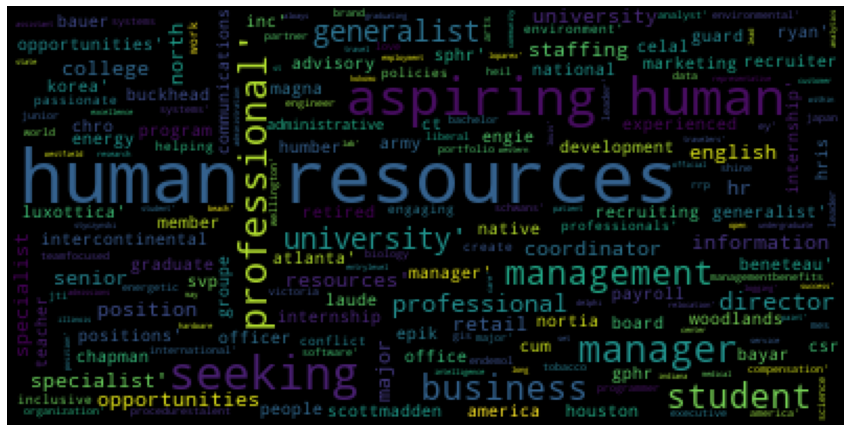

In [24]:
job_titles = data_copy.job_title.values

wordcloud = WordCloud().generate(str(job_titles))

plt.figure(figsize=(15,15))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

This visualization show that there are more job titles with `aspiring human` / `human resources` than with `seeking human resources` .

Now that our dataset has been preprocessed, we can calculate similarity between the keywords and the jo titles of these given candidates. As mentioned above, we will use jaccard and cosine similarities and compare them against each other on which performed better.

## Calculating Similarity Scores

In [25]:
# Defining keywords
keywords = ['aspiring human resources', 'seeking human resources']

### 1. Using Jaccard Similarity

`Jaccard Similarity` = intersection(doc A and doc B) / union(A & B). One means the 2 documents are identical, Zero means there's no similarity between the 2. 
We first need to perform lemmatization (which is the process of reducing words to their root form) to ensure that only unique words are fed on our jaccard similarity.

In [26]:
# Performing lemmatization
from textblob import TextBlob

In [27]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [28]:
def lemmatize(sentence):
    """
        This function takes in a sentence and returns it in its lemmatized form
    """
    text_blob = TextBlob(sentence)
    lemmatized_sentence = " ".join([word.lemmatize() for word in text_blob.words])
    return lemmatized_sentence

In [29]:
# Lemmatizing job titles
lemmatized_titles = data_copy.job_title.apply(lambda x: lemmatize(x))


In [30]:
# type(lemmatized_titles)
data_copy['lemmatized_titles'] = lemmatized_titles

In [31]:
data_copy.head()

,job_title,location,connection,fit,lemmatized_titles
0,ct bauer college business graduate magna cum l...,"Houston, Texas",85,NaN,ct bauer college business graduate magna cum l...
1,native english teacher epik english program korea,Kanada,500,NaN,native english teacher epik english program korea
2,aspiring human resources professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspiring human resource professional
3,people development coordinator ryan,"Denton, Texas",500,NaN,people development coordinator ryan
4,advisory board member celal bayar university,"İzmir, Türkiye",500,NaN,advisory board member celal bayar university


In [32]:
# Lemmatizing the keywords
lemmatized_keywords = []
for keyword in keywords:
    lemmatized_keywords.append(lemmatize(keyword))
lemmatized_keywords

['aspiring human resource', 'seeking human resource']

Now that we've lemmatized our job titles, we can now calculate the similarity score using the jaccard similarity.

In [33]:
def jaccard_similarity(docA, docB):
    """
        Takes in 2 documents/ sentences to be compared.
        Calculates their intersection and union and
        returns similarity score between them.
    """
    # List unique words in a document
    words_docA = set(docA.lower().split())
    words_docB = set(docB.lower().split())
    
    # Intersection between these 2 docmunts
    intersection = words_docA.intersection(words_docB)
    
    # Union between these 2 documents
    union = words_docA.union(words_docB)
    
    # Calculate jaccard similarity score
    return np.round(len(intersection) / len(union),3)

In [34]:
# Calculating the jaccard similarity scores
jaccard_score = []

for title in data_copy.lemmatized_titles.values:
    jac_score1 = jaccard_similarity(title, lemmatized_keywords[0]) 
    jac_score2 = jaccard_similarity(title, lemmatized_keywords[1])
    
    jaccard_score.append((jac_score1 + jac_score2) / 2)

In [35]:
# Store jaccard score to our dataset
data_copy['Jaccard Score'] = jaccard_score 
data_copy.sort_values(by="Jaccard Score", ascending=False) # Re-arrange our data in descending order based on the jaccard score


,job_title,location,connection,fit,lemmatized_titles,Jaccard Score
2,aspiring human resources professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspiring human resource professional,0.5750
5,aspiring human resources specialist,Greater New York City Area,1,NaN,aspiring human resource specialist,0.5750
98,seeking human resources position,"Las Vegas, Nevada Area",48,NaN,seeking human resource position,0.5750
96,aspiring human resources professional,"Kokomo, Indiana Area",71,NaN,aspiring human resource professional,0.5750
27,seeking human resources opportunities,"Chicago, Illinois",390,NaN,seeking human resource opportunity,0.5750
73,human resources professional,Greater Boston Area,16,NaN,human resource professional,0.5000
72,aspiring human resources manager seeking inter...,"Houston, Texas Area",7,NaN,aspiring human resource manager seeking intern...,0.5000
26,aspiring human resources management student se...,"Houston, Texas Area",500,NaN,aspiring human resource management student see...,0.4290
77,human resources generalist schwans,Amerika Birleşik Devletleri,500,NaN,human resource generalist schwans,0.4000
67,human resources specialist luxottica,Greater New York City Area,500,NaN,human resource specialist luxottica,0.4000


### 2. Using Cosine Similarity

We now have to calculate cosine similarity score so we compare both the scores in the end and see which one performed better. Remember that cosine similarity method takes in numeric inputs. That means that we first need to convert our sentences/ job titles and keywords into vector representations before we calculate cosine similarity score. Now, there are numerous ways to do this. The traditional way is using one-hot vector but it won't be suitable for our case since we're dealing with text unlabeled data. Instead, we will play around different word embeddings methods such as `Word2Vec`, `Glove` and`BERT` embeddings to see which one does a better job.

Additionally, it is important to note that word2vec and glove embeddings do not account for word context. BERT embeddings on the other hand learns contextual representations on unlabeled data.

#### 2.1. Doc2Vec Embeddings

Word2Vec tries to learn relationships between words and embeds them in a lower-dimensional vector space. To do this, word2vec trains words against other words that neighbor them in the input corpus, capturing some of the meaning in the sequence of words.

In [ ]:
#Checking if current directory already has trained model
train_doc2vec_model = os.path.isfile('my_doc2vec_model')
if  train_doc2vec_model == False:
    dataset = api.load("text8")
    data = [d for d in dataset]
    def tagged_document(list_of_list_of_words):
        for i, list_of_words in enumerate(list_of_list_of_words):
            yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])
    
    data_training = list(tagged_document(data))
    Doc2Vec_model  = gensim.models.doc2vec.Doc2Vec(vector_size=300, min_count=3, epochs=150)
    Doc2Vec_model.build_vocab(data_training)

    Doc2Vec_model.train(data_training, total_examples=Doc2Vec_model.corpus_count, epochs=Doc2Vec_model.epochs)
    fname = "my_doc2vec_model"
    Doc2Vec_model.save(fname)

In [ ]:
# Loading doc2vec model
doc2vec = Doc2Vec.load('my_doc2vec_model')

In [ ]:
def get_doc2vec_embeddings(job_titles, doc2vec_model):
    """
    Finds the the doc2vec vectors for Job titles.
    args:
    list of job titles 
    doc2vec_model (dictionary): Doc2Vec pre trained embeddings 
    
    return:   
    doc2vec_vectors (list) : list of doc2vec_vectors for job titles
    
    """
    doc2vec_vectors = []
    for title in job_titles:
        sentence_tokens = word_tokenize(title) # break down sentence into words
        tokens = list(filter(lambda x: x in doc2vec_model.wv.index_to_key, sentence_tokens)) # get tokens that are on the pre-trained model
        doc2vec_vectors.append(doc2vec_model.infer_vector(tokens))
    
    return doc2vec_vectors

In [ ]:
# Getting vector representation of ourjob titles and our keywords
doc2vec_vectors = get_doc2vec_embeddings(data_copy.job_title.values, doc2vec)
doc2vec_search_vectors = get_doc2vec_embeddings(keywords, doc2vec)

Now, we calculate cosine similarity score.

In [ ]:
# Cosine similarity
doc2vec_score = []
for i in range(len(doc2vec_vectors)) :
    score1 = cosine_similarity(np.reshape(doc2vec_vectors[i],(1,-1)), np.reshape(doc2vec_search_vectors[0],(1,-1)))
    score2 = cosine_similarity(np.reshape(doc2vec_vectors[i],(1,-1)), np.reshape(doc2vec_search_vectors[1],(1,-1)))
    doc2vec_score.append(np.mean(np.concatenate((score1,score2)).flatten()))
    
data_copy['Doc2Vec Score'] = doc2vec_score
data_copy.sort_values(by=['Doc2Vec Score'],ascending=False)

#### 2.2. Glove Embeddings

In [ ]:
# Checking if there's already any Glove trained model
download_GloVe_embeddings = os.path.isfile('glove.42B.300d.txt.word2vec')


In [ ]:
download_GloVe_embeddings

In [ ]:
if  download_GloVe_embeddings== False:
    url = 'http://nlp.stanford.edu/data/glove.42B.300d.zip'
    filename = wget.download(url)
    print(filename)
    shutil.unpack_archive('glove.42B.300d.zip')
    glove_filename='glove.42B.300d.txt'
    word2vec_output_file = glove_filename+'.word2vec'
    glove2word2vec(glove_filename, word2vec_output_file)

Load glove embeddings that were converted word2vec format

In [ ]:
glove_model = KeyedVectors.load_word2vec_format('glove.42B.300d.txt.word2vec', binary=False)

In [ ]:
def get_glove_embeddings(job_titles, glove_model):
    """
    args: 
    job_titles: list of job titles
    glove_model (dictionary): Glove pre trained embeddings 
    return: 
    glove_vectors (list): list of Glove Vectors for job titles
    """
    
    # Tokenize each job title => find if its words are in glove model
    # => then find them embeddings
    glove_vectors = []
    for title in job_titles:
        token_vector = []
        tokens = word_tokenize(title)
        words_in_glove = [word for word in tokens if word in glove_model.index_to_key]
        
        for token in tokens:
            if token in words_in_glove:
                vector = glove_model[token]
                token_vector.append(vector)
        glove_vectors.append(token_vector)        
                        
    return glove_vectors

In [ ]:
# Vectorize job titles and keywords  for the calculation of cosine similarity score
glove_vectors = get_glove_embeddings(list(data_copy.job_title), glove_model)
search_vectors = get_glove_embeddings(keywords, glove_model)

Now, we calculate cosine similarity score.

In [ ]:
# Cosine Similarity
glove_score = []

for i in range(len(glove_vectors)):
    score0 = cosine_similarity(glove_vectors[i], search_vectors[0])
    score1 = cosine_similarity(glove_vectors[i], search_vectors[1])
    
    glove_score.append((np.mean(score0.flatten()) + np.mean(score1.flatten()) / 2))

In [ ]:
# Add the Glove Score on our dataset and re-arrange dataset in descending order based on the Glove Score
data_copy['Glove Score'] = glove_score
data_copy.sort_values(by=['Glove Score'], ascending=False)

#### 2.3. BERT Embeddings

In [ ]:
# Build BERT_base model
bert_model = SentenceTransformer('bert-base-nli-mean-tokens')
bert_vectors = bert_model.encode(data_copy.job_title.values)
bert_search_vectors = bert_model.encode(keywords)

In [ ]:
# Cosine similarity
bert_score = []
for i in range(len(doc2vec_vectors)) :
    score1 = cosine_similarity(np.reshape(bert_vectors[i],(1,-1)), np.reshape(bert_search_vectors[0],(1,-1)))
    score2 = cosine_similarity(np.reshape(bert_vectors[i],(1,-1)), np.reshape(bert_search_vectors[1],(1,-1)))
    bert_score.append(np.mean(np.concatenate((score1,score2)).flatten()))
    
data_copy['BERT Score'] = bert_score
data_copy.sort_values(by=['BERT Score'],ascending=False)

In [ ]:
data_copy.sort_values(by=['BERT Score'],ascending=False).head()

Above, we've printed the first 5 candidates with the highest BERT Score. From these rows, we can see that the highest BERT Score is more than 90 percent meaning that candidate 98 who lives in Las Vegas has been predicted to be the most fitted candidate for the searched jobs, but their number of connections is 48, which is really small compared to most of the candidates.

Now what we must do now is to include the `connection` column in the calculation of the fitted score.

In [ ]:
def update_fit_score(score,connection):
    improved_score = score - (1/(connection+10))
    return improved_score

def add_connection_to_score(data):
    data['Jaccard Score'] = data.apply(lambda x: update_fit_score(x['Jaccard Score'],x['connection']),axis=1)
    data['GloVe Score'] = data.apply(lambda x: update_fit_score(x['Glove Score'],x['connection']),axis=1)
    data['Doc2Vec Score'] = data.apply(lambda x: update_fit_score(x['Doc2Vec Score'],x['connection']),axis=1)
    data['BERT Score'] = data.apply(lambda x: update_fit_score(x['BERT Score'],x['connection']),axis=1)
    return data

In [ ]:
final_dataset = add_connection_to_score(data_copy)

In [ ]:
final_dataset.head()

In [ ]:
# data_copy.sort_values(by=['Jaccard Score'],ascending=False).head()
# data_copy.sort_values(by=['Glove Score'],ascending=False).head()
# data_copy.sort_values(by=['Doc2Vec Score'],ascending=False).head()
# data_copy.sort_values(by=['BERT Score'],ascending=False).head()
data_copy.sort_values(by=['GloVe Score'],ascending=False).head()

The above are the first 5 rows with the highest fit scores and we can see that BERT score is still the highest.

Now we have to set a threshold value to shortlist candidates, let's set it to 0.5

In [ ]:
shortlisted_candidates = final_dataset[final_dataset['BERT Score'] >=0.5].shape

The above dataset of of all candidates that are shortlisted based on the their BERT fitness score.

### Re-ranking Candidates

Now that we have calculated the fitness score, let us re-rank the candidates when a candidate is starred. We will use them as the search keyword and find fitness score using BERT Embeddings and cosine similarity since BERT out performed the others.

In [ ]:
starred = input('Enter id of the candidate you would like to starr: ')

In [ ]:
# Represent the job title of the starred candidate as bert vectors
rerank_list = final_dataset[final_dataset.index.isin([int(starred)])].job_title.values
rerank_bert_vectors = bert_model.encode(rerank_list)

In [ ]:
# Now let's calculate cosine similarity

rerank_score = []

for i in range(len(bert_vectors)):
    re_rank_score = cosine_similarity(np.reshape(bert_vectors[i],(1,-1)), np.reshape(rerank_bert_vectors[0],(1,-1)))
    rerank_score.append(re_rank_score[0][0])
    
final_dataset['Re-rank BERT Score'] = rerank_score  
final_dataset.sort_values(by=['Rerank Score'],ascending=False)